In [1]:
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
import numpy as np
import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from ms_opto_stim_protocol import OptoStimProtocol
from ms_decoding_tables import ClusterlessAheadBehind


def stim_alligned_states(nwb_file_name, pos_interval, window_ms=100, dlc_model=False):
    if dlc_model:
        position_group_name = "DLC " + pos_interval
    else:
        position_group_name = pos_interval
    decode_key = {
        "nwb_file_name": nwb_file_name,
        "encoding_interval": pos_interval,
        "position_group_name": position_group_name,
    }
    query = ClusterlessDecodingV1() & decode_key & "decoding_param_name LIKE '%causal'"
    if not query:
        return None, None, None
    results = query.fetch_results()
    states = results.causal_posterior.unstack("state_bins").state.values
    state_probabilities = results.causal_posterior.unstack("state_bins").sum(
        "position"
    )[0]
    t_pos = results.time
    position_posterior = results.causal_posterior.unstack("state_bins").sum("state")[0]
    entropy = -np.sum(position_posterior * np.log(position_posterior), axis=-1)

    pos_key = {"nwb_file_name": nwb_file_name, "interval_list_name": pos_interval}
    stim, t_stim = OptoStimProtocol().get_stimulus(pos_key)
    t_on = t_stim[stim == 1]
    ind_on = np.digitize(t_on, t_pos)

    fs = 1 / np.mean(np.diff(t_pos))
    window = int(window_ms / 1000.0 * fs)
    print(window)
    vals = [[], []]
    entropy_list = []
    for ind in ind_on:
        if ind < window or ind >= len(state_probabilities) - window:
            continue
        for ii in range(len(states)):
            vals[ii].append(state_probabilities[ind - window : ind + window, ii])
        entropy_list.append(entropy[ind - window : ind + window])
    vals = np.array(vals)
    entropy_list = np.array(entropy_list)
    # vals[np.abs(vals)>80] = np.nan
    return vals, entropy_list, states

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2024-07-03 14:07:55,146][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-07-03 14:07:55,205][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [2]:
from Analysis.utils import filter_opto_data
from Style.style_guide import animal_style

animal_list = animal_style.index
results = {}
dlc = False

# animal_list = ["Wallie"]
states = None
for animal in animal_list:
    if animal in results:
        continue
    dataset_key = {"animal": animal, "targeted_phase": 90, "track_type": "wtrack"}
    dataset = filter_opto_data(dataset_key)

    vals = [[], []]
    entropy_list = []
    for nwb_file_name, interval in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        vals_i, entropy_i, states_i = stim_alligned_states(
            nwb_file_name, interval, dlc_model=dlc
        )
        if vals_i is None:
            continue
        if states is None:
            states = states_i
        vals[0].extend(vals_i[0])
        vals[1].extend(vals_i[1])
        entropy_list.extend(entropy_i)
        break
    vals = [np.array(v) for v in vals]
    entropy_list = np.array(entropy_list)
    results[animal] = {
        "vals": vals,
        "entropy": entropy_list,
    }

[2024-07-03 14:08:10,122][WARNING]: Skipped checksum for file with hash: af1860ba-d184-e309-273d-720efa577080, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_af845213-5f7f-4d87-b480-b2ea44f6d90a.nc


datasets: 19


[2024-07-03 14:08:45,494][WARNING]: Skipped checksum for file with hash: 0a338b66-5ad3-87c4-0bb1-163250636511, and path: /stelmo/nwb/raw/Winnie20220719_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (34871, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (36413, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-pac

50


[2024-07-03 14:08:48,330][WARNING]: Skipped checksum for file with hash: 94bcb437-1771-efb7-66c4-4abd2a45e9c8, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_1aaa500c-5c7d-43c5-85d7-dc9bdf566d84.nc


datasets: 13


[2024-07-03 14:09:15,873][WARNING]: Skipped checksum for file with hash: 2895e416-9dd1-3611-4d0b-6f28ff4a93c0, and path: /stelmo/nwb/raw/Frodo20230814_.nwb


50


[2024-07-03 14:09:19,530][WARNING]: Skipped checksum for file with hash: e4ccafea-b5ce-3afd-e2ce-4b5b20c49668, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_80287668-9dc0-4991-8744-786a5c070250.nc


datasets: 18


[2024-07-03 14:09:48,379][WARNING]: Skipped checksum for file with hash: e1c94979-9411-ec20-0102-ba4c8b7c452d, and path: /stelmo/nwb/raw/Totoro20220614_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace

50


[2024-07-03 14:09:50,783][WARNING]: Skipped checksum for file with hash: 86066cd0-7ef4-a4f8-dac5-089be9283d48, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_566f97bd-8c5b-4eda-9535-a3fef203f014.nc


datasets: 16
datasets: 0
datasets: 10


[2024-07-03 14:10:17,214][WARNING]: Skipped checksum for file with hash: 8e4c27ce-6d3e-81a9-2bc5-d068cd98d78c, and path: /stelmo/nwb/raw/Wallie20220922_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace

50


[2024-07-03 14:10:19,826][WARNING]: Skipped checksum for file with hash: 08635c36-5d4c-35ce-abd4-d178d65a4ff1, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_05ac4763-4e76-450c-8fdf-f3380e9c1956.nc


datasets: 8


[2024-07-03 14:10:47,091][WARNING]: Skipped checksum for file with hash: 8e9cc1ba-3e87-2a2a-8edd-40f2ea111b9d, and path: /stelmo/nwb/raw/Olive20220711_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace 

50


[2024-07-03 14:10:49,967][WARNING]: Skipped checksum for file with hash: b0ccafb4-f42d-fc39-1cea-035094ba3de1, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_a1d3f35e-5390-4ed3-9950-897bdc05290f.nc


datasets: 16


[2024-07-03 14:11:12,504][WARNING]: Skipped checksum for file with hash: a1668a28-f06d-3c01-37c5-0bcd9019b6eb, and path: /stelmo/nwb/raw/Yoshi20220517_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace 

50


[2024-07-03 14:11:14,595][WARNING]: Skipped checksum for file with hash: 52c3504e-5ab0-14d6-c42f-ca0790b84631, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_d9889acb-9596-4060-91a4-cdd622598d57.nc


datasets: 8


[2024-07-03 14:11:35,902][WARNING]: Skipped checksum for file with hash: b2c9164a-2a16-a579-0981-4151e3444234, and path: /stelmo/nwb/raw/Bilbo20230802_.nwb


50


In [17]:
dataset

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,dio_event_name the name assigned to this DIO event,opto_infer_params_name name for this set of parameters,optogenetic_protocol name of optogenetic protocol type (e.g. pulse train),pulse_length_ms length of individual pulse,inter_pulse_interval_ms time between pulses in a train (= np.nan if pulses_per_train=1 or phase-targeting feedback),inter_train_interval_ms time between end of train and start of new one (= np.nan if phase-targeting feedback),period_ms time between successive train starts (= np.nan if phase-targeting feedback),pulses_per_train number of pulses in a train,number_trains mean number of train events observed between behavior-off intervals,stim_on whether any optogenetic stimulus occured in this interval,test_intervals numpy array with start and end times for each interval optogenetics is running,control_intervals numpy array with start and end times for each interval optogenetics is off,targeted_phase targeted phase of theta (in degrees)
Wallie20220922_.nwb,pos 1 valid times,stim,default_phase_targeting,phase_targeting,40,90,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 11 valid times,stim,default_phase_targeting,phase_targeting,40,73,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 13 valid times,stim,default_phase_targeting,phase_targeting,40,75,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 15 valid times,stim,default_phase_targeting,phase_targeting,40,74,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 17 valid times,stim,default_phase_targeting,phase_targeting,40,73,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 19 valid times,stim,default_phase_targeting,phase_targeting,40,61,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 3 valid times,stim,default_phase_targeting,phase_targeting,40,78,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 5 valid times,stim,default_phase_targeting,phase_targeting,40,77,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 7 valid times,stim,default_phase_targeting,phase_targeting,40,77,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Wallie20220922_.nwb,pos 9 valid times,stim,default_phase_targeting,phase_targeting,40,74,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90


In [19]:
# nwb_file_name = "Wallie20220922_.nwb"

# decode_key = {"nwb_file_name":nwb_file_name,
#                               #  "encoding_interval":interval,
#                             #    "position_group_name":position_group_name,
#                             }
# query = ClusterlessDecodingV1() "position_group_name LIKE DLC#& decode_key #& "decoding_param_name LIKE '%causal'"
# query

In [18]:
# val[0].shape
animal
val = np.array([v for v in val if v.size == 100]).shape

(34093, 100)

/tmp/ipykernel_1806314/284106007.py:28: RuntimeWarning: Mean of empty slice
  ax[2].plot(t_plot, np.nanmean(entropy, axis=0), color=color, label=animal)


(-60.0, 60.0)

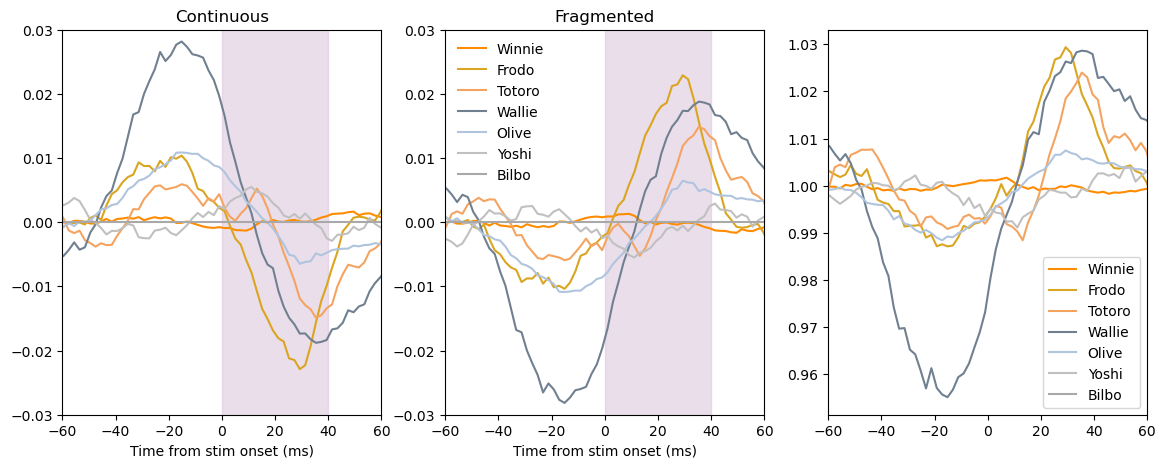

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=False)
window = 100

for animal in results:
    vals = results[animal]["vals"]
    if not len(vals[0]):
        continue
    color = animal_style.loc[animal].color
    for a, val, state in zip(ax, vals, states):
        val = np.array([v for v in val if v.size == 100])
        t_plot = np.linspace(-window, window, val[0].shape[0])

        val = val - np.nanmean(val, axis=1)[:, None]
        # val = val/np.nanmax(np.abs(val), axis=1)[:,None]
        a.plot(t_plot, np.nanmean(val, axis=0), color=color, label=animal)

        # plot_val = np.nanmean(val>.3, axis=0)
        # plot_val = plot_val-np.nanmean(plot_val)
        # a.plot(t_plot,plot_val,color=color, label=animal)

        a.set_title(state)
        a.set_xlabel("Time from stim onset (ms)")

    entropy = results[animal]["entropy"]
    entropy = entropy / np.nanmean(entropy, axis=1)[:, None]
    ax[2].plot(t_plot, np.nanmean(entropy, axis=0), color=color, label=animal)
ax[2].legend()
ax[1].legend(frameon=False)
for a in ax[:-1]:
    a.fill_between([0, 40], -0.1, 0.1, color="thistle", alpha=0.5)
    scale = 0.03
    a.set_ylim(-scale, scale)

# window = 100
# for a,val, state in zip(ax,vals, states):
#     t_plot = np.linspace(-window, window,val.shape[1])
#     a.plot(t_plot, np.nanmean(val, axis=0))
#     a.set_title(state)

a.set_xlim(-60, 60)

In [28]:
dataset

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,dio_event_name the name assigned to this DIO event,opto_infer_params_name name for this set of parameters,optogenetic_protocol name of optogenetic protocol type (e.g. pulse train),pulse_length_ms length of individual pulse,inter_pulse_interval_ms time between pulses in a train (= np.nan if pulses_per_train=1 or phase-targeting feedback),inter_train_interval_ms time between end of train and start of new one (= np.nan if phase-targeting feedback),period_ms time between successive train starts (= np.nan if phase-targeting feedback),pulses_per_train number of pulses in a train,number_trains mean number of train events observed between behavior-off intervals,stim_on whether any optogenetic stimulus occured in this interval,test_intervals numpy array with start and end times for each interval optogenetics is running,control_intervals numpy array with start and end times for each interval optogenetics is off,targeted_phase targeted phase of theta (in degrees)
Totoro20220613_.nwb,pos 1 valid times,stim,default_phase_targeting,phase_targeting,40,41,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220613_.nwb,pos 3 valid times,stim,default_phase_targeting,phase_targeting,40,41,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 1 valid times,stim,default_phase_targeting,phase_targeting,40,41,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 11 valid times,stim,default_phase_targeting,phase_targeting,40,48,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 13 valid times,stim,default_phase_targeting,phase_targeting,40,41,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 15 valid times,stim,default_phase_targeting,phase_targeting,40,41,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 3 valid times,stim,default_phase_targeting,phase_targeting,40,61,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 5 valid times,stim,default_phase_targeting,phase_targeting,39,61,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 7 valid times,stim,default_phase_targeting,phase_targeting,40,64,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
Totoro20220614_.nwb,pos 9 valid times,stim,default_phase_targeting,phase_targeting,40,61,-1,-1,-1,-1.0,1,=BLOB=,=BLOB=,90
